In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *
from scipy import signal

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

# rerun jets for paper

In [2]:
dh = DataHandler.from_specs("ERA5", "plev", ("high_wind", "s"), "6H", "all", None, -80, 40, 15, 80, "all")

In [3]:
dh_high = DataHandler.from_specs("ERA5", "plev", "high_wind", "6H", "all", None, -80, 40, 15, 80, "all")
dh_low = DataHandler.from_specs("ERA5", "plev", "low_wind", "6H", "all", None, -80, 40, 15, 80, "all")
exp = JetFindingExperiment(dh_high)
all_jets = exp.find_jets()
exp.categorize_jets(dh_low.da["s"])
exp.track_jets()
exp.props_as_df()
da_pos = jet_position_as_da(exp.find_jets())

In [8]:
X = extract_features(all_jets, ("theta", "ratio"), 1)
x, _, _ = normalize(X)

In [15]:
x

theta,ratio
f64,f32
1.10035,-1.042523
1.10035,-1.042523
1.010752,-1.045212
1.010752,-1.045212
0.995572,-0.896806
…,…
-0.345421,1.034351
-0.350318,1.087657
-0.352908,1.127077


In [5]:
import pymc as pm

In [ ]:
k = 2
n = X.shape[1]
with pm.Model() as model:
    cov = pm.HalfNormal("sigma", sigma=1, shape=(n, n, k))
    mu = pm.Normal(
        "μ",
        mu=[-1, 1],
        sigma=2,
        shape=(n, k),
    )
    weights = pm.Dirichlet("w", np.ones(k), shape=(k))

    components = pm.MvNormal.dist(mu=mu, cov=cov, shape=(2, 2))
    like = pm.Mixture("like", w=weights, comp_dists=components, observed=x)

with model:
    idata = pm.sample()

In [ ]:
idata

like

In [ ]:
plt.ion()
MYPURPLES = LinearSegmentedColormap.from_list("mypurples", ["#ffffff", COLORS_EXT[4], COLORS_EXT[5]])
MYPINKS = LinearSegmentedColormap.from_list("mypinks", ["#ffffff", COLORS_EXT[7], COLORS_EXT[8]])

to_plot_1 = []
to_plot_2 = []
for month in range(1, 13):
    this_da = da_pos.sel(time=da_pos.time.dt.month == month)
    to_plot_1.append((this_da < 0.1).mean("time"))
    to_plot_2.append((this_da > 0.9).mean("time"))

In [35]:
clu = Clusterplot(3, 4, get_region(da_pos))
im, kwargs = clu.add_contourf([tp2 for tp2 in to_plot_2], transparify=1, levels=8, cmap=colormaps.gothic_r, draw_cbar=False)
cbar = clu.fig.colorbar(im, ax=clu.axes, shrink=0.99, pad=0.01)
cbar.ax.set_ylabel("Eddy-driven jet occurence [1 / 6H]", fontsize=13)
im, kwargs = clu.add_contourf([tp1 for tp1 in to_plot_1], transparify=1, levels=7, cmap=colormaps.flamingo_r, draw_cbar=False)
cbar = clu.fig.colorbar(im, ax=clu.axes, shrink=0.99, pad=0.01)
cbar.ax.set_ylabel("Subtropical jet occurence [1 / 6H]", fontsize=13)
for ax, month in zip(clu.axes, range(1, 13)):
    ax.annotate(str(month), (2.2, 5), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
clu.resize_relative([1.0, 0.89])
plt.savefig(f"{FIGURES}/jet_props_misc/new_is_polar_map.png")
plt.show()
time.sleep(1)
clear_output()
time.sleep(1)

In [45]:
all_jets = exp.find_jets()
X = extract_features(all_jets, ("theta", "ratio"), 1)
X, _, _ = normalize(X)

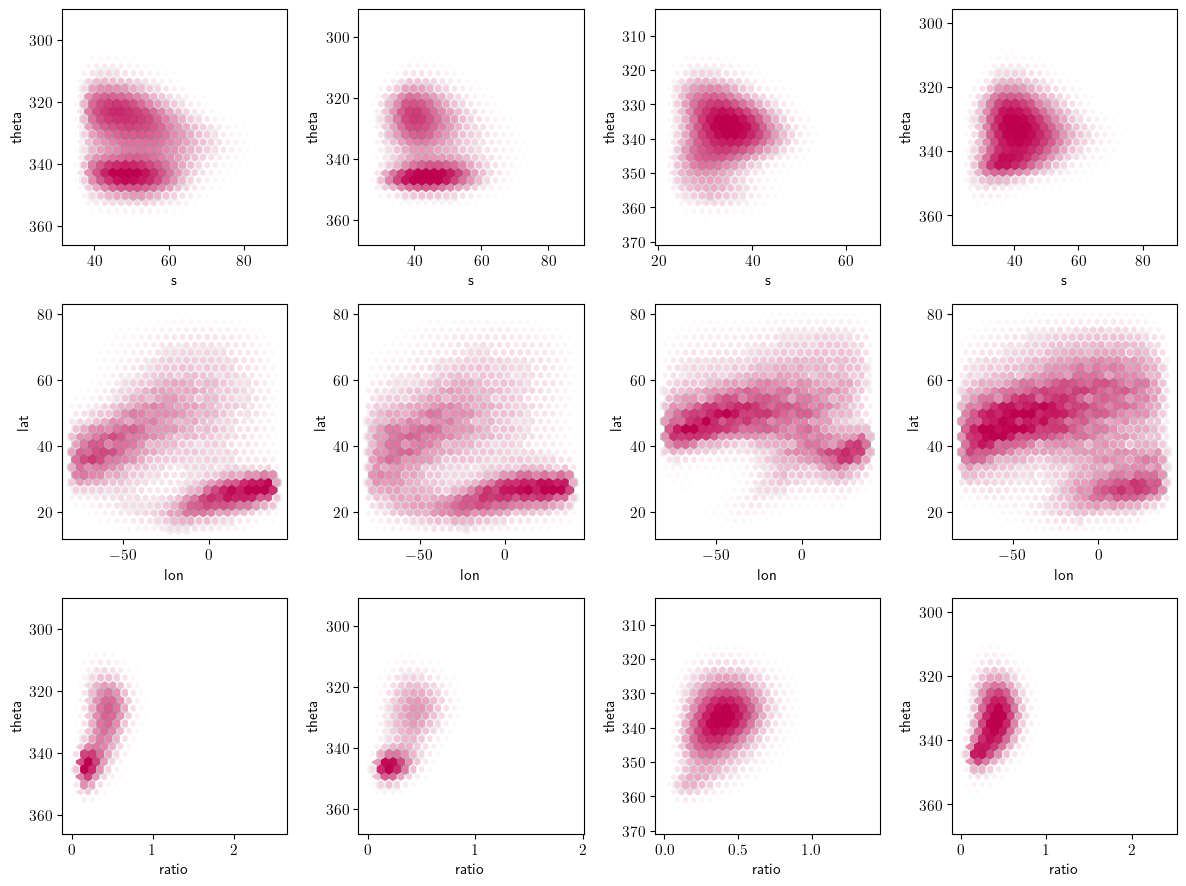

In [34]:
pairs = [["s", "theta"], ["lon", "lat"], ["ratio", "theta"]]
seasons = list(SEASONS)
fig, axes = plt.subplots(len(pairs), len(seasons), figsize=(3 * len(seasons), 3 * len(pairs)), tight_layout=True)
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
for axs, season in zip(axes.T, seasons):
    these_jets = all_jets.filter(pl.col("time").dt.month().is_in(SEASONS[season]))
    for ax, pair in zip(axs, pairs):
        im1 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], cmap=colormaps.greys, gridsize=25)
        im2 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], C=these_jets["is_polar"], cmap=cmap, gridsize=25)
        
        plt.draw()
        
        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        colors = cmap(im2.get_array())
        colors = rgb_to_hsv(colors[:, :3])
        min_s, max_s = 0., 1.0
        min_v, max_v = 0.75, 1.
        scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
        f = lambda x: np.sqrt(x)
        colors[:, 1] = min_s + scaling * (max_s - min_s)
        colors[:, 2] = max_v - scaling * (max_v - min_v)
        colors = hsv_to_rgb(colors)
        im2.set_array(None)
        im2.set_facecolor(colors)
        # im2.set_linewidths(0.2)
        im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
        im2.set_edgecolor(colormaps.greys(scaling))
        im2 = ax.add_collection(im2)
        
        ax.set_xlabel(pair[0])
        ax.set_ylabel(pair[1])
        if pair[0] in ["lev", "theta"]:
            ax.invert_xaxis()
        elif pair[1] in ["lev", "theta"]:
            ax.invert_yaxis() 
            
        plt.draw()

# jet cat with more features, from all-globe jets

In [ ]:
# ds = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/1959.nc")
# dh = DataHandler(ds, "/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results")
# exp = JetFindingExperiment(dh)
all_jets = pl.read_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results/3/all_jets_one_df2.parquet")

In [ ]:
natl_jets = all_jets.filter(pl.col("lat") >= 10, pl.col("lat") <= 80, pl.col("lon") >= -80, pl.col("lon") <= 40)
natl_jets = is_polar_gmix(natl_jets, ["ratio", "theta"], "month")

In [ ]:
natl_jets.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results/3/all_jets_one_df_natl.parquet")

In [ ]:
pairs = [["s", "theta"], ["lon", "lat"], ["ratio", "theta"]]
seasons = list(SEASONS)
fig, axes = plt.subplots(len(pairs), len(seasons), figsize=(3 * len(seasons), 3 * len(pairs)), tight_layout=True)
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
for axs, season in zip(axes.T, seasons):
    these_jets = natl_jets.filter(pl.col("time").dt.month().is_in(SEASONS[season]))
    for ax, pair in zip(axs, pairs):
        im1 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], cmap=colormaps.greys, gridsize=25)
        im2 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], C=these_jets["is_polar"], cmap=cmap, gridsize=25)
        
        plt.draw()
        
        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        colors = cmap(im2.get_array())
        colors = rgb_to_hsv(colors[:, :3])
        min_s, max_s = 0., 1.0
        min_v, max_v = 0.75, 1.
        scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
        f = lambda x: np.sqrt(x)
        colors[:, 1] = min_s + scaling * (max_s - min_s)
        colors[:, 2] = max_v - scaling * (max_v - min_v)
        colors = hsv_to_rgb(colors)
        im2.set_array(None)
        im2.set_facecolor(colors)
        # im2.set_linewidths(0.2)
        im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
        im2.set_edgecolor(colormaps.greys(scaling))
        im2 = ax.add_collection(im2)
        
        ax.set_xlabel(pair[0])
        ax.set_ylabel(pair[1])
        if pair[0] in ["lev", "theta"]:
            ax.invert_xaxis()
        elif pair[1] in ["lev", "theta"]:
            ax.invert_yaxis() 
            
        plt.draw()

In [ ]:
all_jets = all_jets_one_df

In [ ]:
pairs = [["s", "theta"], ["lon", "lat"], ["ratio", "theta"]]
seasons = list(SEASONS)
fig, axes = plt.subplots(len(pairs), len(seasons), figsize=(3 * len(seasons), 3 * len(pairs)), tight_layout=True)
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
for axs, season in zip(axes.T, seasons):
    these_jets = all_jets.filter(pl.col("time").dt.month().is_in(SEASONS[season]))
    for ax, pair in zip(axs, pairs):
        im1 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], cmap=colormaps.greys, gridsize=25)
        im2 = ax.hexbin(these_jets[pair[0]], these_jets[pair[1]], C=these_jets["is_polar"], cmap=cmap, gridsize=25)
        
        plt.draw()
        
        offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
        offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
        mask12 = np.isin(offsets1, offsets2)
        colors = cmap(im2.get_array())
        colors = rgb_to_hsv(colors[:, :3])
        min_s, max_s = 0., 1.0
        min_v, max_v = 0.75, 1.
        scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
        f = lambda x: np.sqrt(x)
        colors[:, 1] = min_s + scaling * (max_s - min_s)
        colors[:, 2] = max_v - scaling * (max_v - min_v)
        colors = hsv_to_rgb(colors)
        im2.set_array(None)
        im2.set_facecolor(colors)
        # im2.set_linewidths(0.2)
        im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
        im2.set_edgecolor(colormaps.greys(scaling))
        im2 = ax.add_collection(im2)
        
        ax.set_xlabel(pair[0])
        ax.set_ylabel(pair[1])
        if pair[0] in ["lev", "theta"]:
            ax.invert_xaxis()
        elif pair[1] in ["lev", "theta"]:
            ax.invert_yaxis() 
            
        plt.draw()

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 0, pl.col("lon") > -80, pl.col("lon") < 100), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio", "EKE"], season="JJA")

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 15, pl.col("lat") < 80, pl.col("lon") >= -80, pl.col("lon") <= 40), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio"], season=7)
# X = X.with_columns(pl.col("ratio").clip(0, 0.75))
is_polar = one_gmix(X[["s", "ratio", "theta"]], n_components=2, init_params="k-means++", n_init=10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"gridsize": 31}
pairs = [["lon", "lat"], ["lat", "lev"], ["s", "theta"], ["s", "lev"], ["ratio", "theta"], ["ratio", "lat"]]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
for ax, pair in zip(axes, pairs):
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.greys, **kwargs)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=is_polar, cmap=cmap, **kwargs)
    
    plt.draw()
    
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
    
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    plt.draw()

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 15, pl.col("lat") < 80), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio"], season="JJA")
is_polar = one_gmix(X[["lat", "theta", "ratio"]])
fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"cmap": colormaps.balance, "gridsize": 31, "C": is_polar}
pairs = [["lon", "lat"], ["lat", "lev"], ["s", "theta"], ["s", "lev"], ["ratio", "theta"], ["ratio", "lat"]]
for ax, pair in zip(axes, pairs):
    im = ax.hexbin(X[pair[0]], X[pair[1]], **kwargs)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 15, pl.col("lat") < 80), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio"], season="SON")
X = X.with_columns(pl.col("ratio").clip(0, 0.75))
fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"cmap": cmap, "gridsize": 31}
pairs = [["lon", "lat"], ["lat", "lev"], ["s", "theta"], ["s", "lev"], ["ratio", "theta"], ["ratio", "lat"]]
for ax, pair in zip(axes, pairs):
    ax.hexbin(X[pair[0]], X[pair[1]], **kwargs)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 15, pl.col("lat") < 80), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio"], season="DJF")
X = X.with_columns(pl.col("ratio").clip(0, 0.75))
fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"cmap": cmap, "gridsize": 31}
pairs = [["lon", "lat"], ["lat", "lev"], ["s", "theta"], ["s", "lev"], ["ratio", "theta"], ["ratio", "lat"]]
for ax, pair in zip(axes, pairs):
    ax.hexbin(X[pair[0]], X[pair[1]], **kwargs)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 

In [ ]:
X = extract_features(all_jets.filter(pl.col("lat") > 15, pl.col("lat") < 80), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio"], season="MAM")
X = X.with_columns(pl.col("ratio").clip(0, 0.75))
fig, axes = plt.subplots(2, 3, figsize=(12, 8), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"cmap": cmap, "gridsize": 31}
pairs = [["lon", "lat"], ["lat", "lev"], ["s", "theta"], ["s", "lev"], ["ratio", "theta"], ["ratio", "lat"]]
for ax, pair in zip(axes, pairs):
    ax.hexbin(X[pair[0]], X[pair[1]], **kwargs)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
axes = axes.ravel()
cmap = colormaps.matter
kwargs = {"cmap": cmap, "gridsize": 25}
pair = ["ratio", "theta"]
for ax, season in zip(axes, SEASONS):
    Xp= extract_features(all_jets.filter(pl.col("lat") > 0, pl.col("lon") > -80, pl.col("lon") < 100), ["lon", "lat", "lev", "s", "theta", "s_low", "ratio", "EKE"], season=season)
    ax.hexbin(Xp[pair[0]], Xp[pair[1]], **kwargs)
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
    ax.set_title(season)

In [ ]:
clu = Clusterplot(1, 1, get_region(ds))
it = np.random.choice(len(ds.time))
clu.add_contourf([ds["s"][it]], cmap=colormaps.greys, levels=7)
jets = all_jets.filter(pl.col("time") == ds["time"][it]) 
norm = Normalize(all_jets["theta"].quantile(0.05), all_jets["theta"].quantile(0.95))
for indexer, jet in jets.group_by("jet ID"):
    lon, lat, theta = jet[["lon", "lat", "theta"]].to_numpy().T
    plt.scatter(lon, lat, c=theta, lw=1, s=10, norm=norm, cmap=colormaps.thermal)

# arco-era5 tests

In [ ]:
ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"),
)
ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)

base_ds = (
    ar_full_37_1h[["u_component_of_wind", "v_component_of_wind"]]
    .sel(
        time=ar_full_37_1h.time.dt.hour % 6 == 0,
        latitude=ar_full_37_1h.latitude >= 0,
        level=[175, 200, 225, 250, 300, 350],
    )
    .isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))
)

base_path = Path(f"{DATADIR}/ERA5/plev/flat_wind/dailymean")
for year in YEARS:
    for month in range(1, 13):
        month_str = str(month).zfill(2)
        opath = base_path.joinpath(f"{year}{month_str}.nc")
        if opath.is_file():
            continue
        ds = compute(
            base_ds.sel(
                time=(base_ds.time.dt.year == year) & (base_ds.time.dt.month == month)
            ),
            progress=True,
        )
        ds = standardize(ds)
        ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
        ds = flatten_by(ds, "s")
        ds.to_netcdf(opath)
        print(f"Completed {year}{month}")

In [ ]:
ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"),
)
ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)

temp_full = (
    ar_full_37_1h["temperature"]
    .sel(
        time=ar_full_37_1h.time.dt.hour % 6 == 0,
        latitude=ar_full_37_1h.latitude >= 0,
        level=[175, 200, 225, 250, 300, 350],
    )
    .isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))
)

temp_full = standardize(temp_full)

In [ ]:
ds = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3",
    chunks=None,
    storage_options=dict(token="anon"),
)
ar_full_37_1h = ds.sel(
    time=slice(ds.attrs["valid_time_start"], ds.attrs["valid_time_stop"])
)

temp_full = (
    ar_full_37_1h["temperature"]
    .sel(
        time=ar_full_37_1h.time.dt.hour % 6 == 0,
        latitude=ar_full_37_1h.latitude >= 0,
        level=[175, 200, 225, 250, 300, 350],
    )
    .isel(longitude=slice(None, None, 2), latitude=slice(None, None, 2))
)

temp_full = standardize(temp_full)

orig_path = Path(f"{DATADIR}/ERA5/plev/flat_wind/dailymean")
base_path = Path(f"{DATADIR}/ERA5/plev/flat_wind/dailymean_2")
for year in tqdm(YEARS):
    for month in trange(1, 13, leave=False):
        month_str = str(month).zfill(2)
        opath = base_path.joinpath(f"{year}{month_str}.nc")
        if opath.is_file():
            continue
        ipath = orig_path.joinpath(f"{year}{month_str}.nc")
        ds = xr.open_dataset(ipath)
        this_temp = temp_full.sel(time=ds.time.values, lev=ds["lev"])
        this_temp = this_temp * (1000 / this_temp.lev) ** KAPPA
        this_temp = this_temp.reset_coords("lev", drop=True)
        ds["theta"] = compute(this_temp, progress_flag=True)
        ds.to_netcdf(opath)

# Climatologies, datahandlers of new data

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "t2m", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "tp", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "sst", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "surf", "mslp", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "apvs", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "cpvs", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "thetalev", "apvs", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=True)
    da.to_netcdf(data_path("ERA5", "thetalev", "apvs", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "plev", "z", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=True)
    da.to_netcdf(data_path("ERA5", "plev", "z", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
compute_all_smoothed_anomalies("ERA5", "plev", "z", "dailymean", 'dayofyear', {'dayofyear': ('win', 15)}, None)

In [ ]:
for year in tqdm(YEARS):
    da = open_da("ERA5", "thetalev", "cpvs", "6H", period=[year])
    da = compute(da.chunk({"lev": 1}).resample(time="1d").mean(), progress_flag=False)
    da.to_netcdf(data_path("ERA5", "thetalev", "cpvs", "dailymean").joinpath(f"{year}.nc"))

In [ ]:
da_ = compute(da.sel(lev=350), progress_flag=True)

In [ ]:
da_

In [ ]:
da_ = pl.from_pandas(da_.to_dataframe().reset_index()).cast({"lat": pl.Float32, "lon": pl.Float32, "lev": pl.UInt16})

In [ ]:
da_

In [ ]:
da_.group_by(pl.col("time").dt.ordinal_day(), pl.col("lat"), pl.col("lon")).agg(pl.col("apvs").mean())

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "apvs", "6H", 'hourofyear', {'hourofyear': ('win', 60)}, None)

In [ ]:
compute_all_smoothed_anomalies("ERA5", "thetalev", "cpvs", "6H", 'hourofyear', {'hourofyear': ('win', 60)}, None)

# new pvs das

In [ ]:
import polars_st as st

In [ ]:
def to_xarray(events: st.GeoDataFrame, dummy_da: xr.DataArray, varname: str):
    dummy_da = dummy_da.rename("dummy")
    da_df = pl.from_pandas(dummy_da.to_dataframe().reset_index())
    orig_times = da_df["time"]
    timedtype = orig_times.dtype
    da_df = da_df.drop("time", "dummy")
    da_df = da_df.unique(["lat", "lon"]).sort(["lat", "lon"]).with_columns(geometry=st.from_xy("lon", "lat"))
    da_df = st.GeoDataFrame(da_df)
    events = events.with_columns(pl.col("geometry").st.buffer(0.25))
    events = (
        events.select(["date", "geometry", varname])
        .cast({varname: pl.Float32})
        .rename({"date": "time"})
    )
    events = events.cast({"time": timedtype})
    events = events.filter(pl.col("time").is_in(orig_times))
    dummy_da = xr.zeros_like(dummy_da, dtype=np.float32)
    events = events.st.sjoin(da_df, on="geometry", how="inner", predicate="contains")
    events = events.unique(["time", "lon", "lat"])
    events_da = xr.DataArray.from_series(
        events[["time", varname, "lat", "lon"]]
        .to_pandas()
        .set_index(["time", "lat", "lon"])[varname]
    ).fillna(0)
    dummy_da.loc[
        {
            "time": events_da.time.values,
            "lat": events_da.lat.values,
            "lon": events_da.lon.values,
        }
    ] = events_da
    return dummy_da

In [ ]:
all_events = {}
for level in trange(310, 365, 5):
    events = st.from_geopandas(gpd.read_parquet(f"/storage/workspaces/giub_meteo_impacts/ci01/ERA5/RWB_index/era5_pv_streamers_{level}K_1959-2022.parquet"))

    tropospheric = events.filter(pl.col("mean_var") < pl.col("level"))
    anticyclonic = tropospheric.filter(pl.col("intensity") >= pl.col("level"))
    cyclonic = tropospheric.filter(pl.col("intensity") < pl.col("level"))
    
    all_events[level] = {"anti": anticyclonic, "cycl": cyclonic}

In [ ]:
for year in YEARS:
    # for month in range(1, 13):
    ofile_anti = Path(f"{DATADIR}/ERA5/thetalev/apvs/6H/{year}.nc")
    ofile_cycl = Path(f"{DATADIR}/ERA5/thetalev/cpvs/6H/{year}.nc")
    if ofile_cycl.is_file() and ofile_anti.is_file():
        continue
    time_mask = (TIMERANGE.year == year)# & (TIMERANGE.month == month)
    coords = {
        "time": TIMERANGE[time_mask],
        "lat": np.arange(0, 90.5, .5),
        "lon": np.arange(-180, 180, .5),
    }
    shape = [len(co) for co in coords.values()]
    dummy_da = xr.DataArray(np.zeros(shape), coords=coords)
    anti_all_levs = {}
    cycl_all_levs = {}
    for lev, events in tqdm(all_events.items(), total=11):
        anti_all_levs[lev] = to_xarray(events["anti"], dummy_da, "intensity")
        cycl_all_levs[lev] = to_xarray(events["cycl"], dummy_da, "intensity")
    anti_all_levs = xr.concat(anti_all_levs.values(), dim="lev").assign_coords(lev=list(anti_all_levs))
    cycl_all_levs = xr.concat(cycl_all_levs.values(), dim="lev").assign_coords(lev=list(cycl_all_levs))
    anti_all_levs.to_netcdf(ofile_anti)
    cycl_all_levs.to_netcdf(ofile_cycl)

# CESM

In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
basepath = Path("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind")
paths = list(basepath.iterdir())
paths = [path for path in paths if path.suffix == ".nc" and path.name != "ds.nc"]
parts = [path.name.split(".")[0].split("-") for path in paths]
parts = np.asarray(parts)
sorted_order = np.argsort([memb.replace("r10", "r0") for memb in parts[:, 0]])
parts = parts[sorted_order]
paths = [paths[i] for i in sorted_order]
all_members = np.unique(parts[:, 0])
all_years = np.unique(parts[:, 1])

not_here = []
here = []
for year in all_years:
    for member in all_members:
        potential_path = basepath.joinpath(f"{member}-{year}.nc")
        if potential_path.is_file():
            here.append(potential_path)
        else:
            not_here.append(potential_path)
len(here)

from itertools import groupby
paths_to_load = []
valid_ensembles = []
for key, indices in groupby(range(len(parts)), lambda i: parts[i][0]):
    indices = list(indices)
    group = parts[indices]
    these_paths = [paths[i] for i in indices]
    years = np.asarray(list([g[1] for g in group]))
    if len(years) == 60:
        paths_to_load.append(these_paths)
        valid_ensembles.append(key)
    else:
        print(key, len(years))

In [ ]:
from tqdm import tqdm
ds = []
for ptl in tqdm(paths_to_load):
    ds_ = []
    for p in ptl:
        this = xr.open_dataset(p)
        this = this.reset_coords("time_bnds", drop=True).drop_dims("nbnd")
        ds_.append(this)
    ds.append(xr.concat(ds_, dim="time"))
ds = xr.concat(ds, dim="member")
# ds = xr.concat([xr.concat([xr.open_dataset[ptl_] for ptl_ in ptl], dim="time") for ptl in paths_to_load], dim="member")

In [ ]:
import dask
from dask.distributed import progress, Client
from jetstream_hugo.definitions import COMPUTE_KWARGS
client = Client(**COMPUTE_KWARGS)
dask.persist(ds)
progress(ds, notebook=False)
ds = dask.compute(ds)

In [ ]:
ds = ds[0]
to_comp = ds.to_zarr(f"/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", compute=False, encoding={var: {"chunks": (-1, 100, -1, -1)} for var in ds.data_vars}, mode="w")
dask.persist(to_comp)
progress(to_comp, notebook=False)
dask.compute(to_comp)